# Sentiment Analysis and Prediction: A Hybrid Model

This is a sentiment analysis and prediction model that uses a hybrid approach with feature extraction. The model combines deep learning and classical machine learning: a deep learning model extracts features from movie reviews, and an SVM classifier model uses these features to analyze the sentiment (positive or negative) in reviews. The dataset used was the IMDb Dataset of 50K Movie Reviews.

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Attention, Flatten, Dropout, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

pd.set_option("display.max_columns", None)
pd.set_option('future.no_silent_downcasting', True)

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
plt.rcParams['font.family'] = 'Arial'
sns.set_style('whitegrid')

%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
# Read the train and test datasets
def read_text_files(directory):
    texts = []
    labels = []
    for label in ['pos', 'neg']:
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            with open(os.path.join(label_dir, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
                labels.append(label)
    return texts, labels

train_texts, train_labels = read_text_files('train')
test_texts, test_labels = read_text_files('test')

# Combine texts and labels into DataFrames
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

# Shuffle the DataFrames to randomize the order of reviews
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
train_df.head()

,text,label
0,In Panic In The Streets Richard Widmark plays ...,pos
1,If you ask me the first one was really better ...,neg
2,I am a big fan a Faerie Tale Theatre and I've ...,pos
3,I just finished reading a book about Dillinger...,neg
4,Greg Davis and Bryan Daly take some crazed sta...,neg


In [4]:
test_df.head()

,text,label
0,"When I was a kid, I loved ""Tiny Toons"". I espe...",pos
1,"The setup for ""Nature of the Beast"" is ingenio...",neg
2,I do not have much to say than this is a great...,pos
3,Extremely formulaic with cosmic-sized logic ho...,neg
4,I actually liked certain things about this gam...,neg


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [6]:
# Check for NaNs
nan_value = train_df.isnull().values.any()
nan_result = train_df.isnull().sum()

print("Any missing values (NaNs):", nan_value)
print("\nCount of missing values (NaNs) for each column:")
print(nan_result)

Any missing values (NaNs): False

Count of missing values (NaNs) for each column:
text     0
label    0
dtype: int64


In [7]:
# Check for duplicates
duplicate_value = train_df.duplicated().any()
duplicate_result = train_df.duplicated().sum()

print("Any duplicate values:", duplicate_value)
print("\nCount of duplicate rows:", duplicate_result)

Any duplicate values: True

Count of duplicate rows: 96


In [8]:
# Drop duplicate values
train_df.drop_duplicates(inplace=True)

In [9]:
# Check for data imbalance in the target
train_df['label'].value_counts()

label
pos    12472
neg    12432
Name: count, dtype: int64

In [10]:
# Extract text and labels from DataFrames
X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
y_test = test_df['label']

In [11]:
# Calculate average review length
average_length = X_train.apply(lambda x: len(x.split())).mean()

print(f"The average length of the reviews is: {average_length:.0f} words")

The average length of the reviews is: 234 words


We use the average length of the texts to set the maximum padding length to 270.

In [12]:
# Preprocess the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=270, padding='post')
X_test = pad_sequences(X_test, maxlen=270, padding='post')

In [13]:
# Initialize and fit the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Transform labels to numerical format
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# Inspect the label encoder mapping
labels = label_encoder.classes_
print("Classes:", labels)
print("Class to number mapping:", dict(zip(labels, range(len(labels)))))

Classes: ['neg' 'pos']
Class to number mapping: {'neg': 0, 'pos': 1}


We create a complex model with the following layer(s):

* embedding layer - to transform text into vector representations, enabling the model to work with text data more efficiently

* bidirectional LSTM (BiLSTM) layer - to process data in both forward and backward directions to capture more context

* LSTM layers - to handle long-term dependencies in the data

* attention layer - to allow the model to weigh and focus on different parts of the input sequence when processing each element. The attention tensor was fed twice to use it as self-attention. The layer is also scaled to be similar to the one in the original Transformer paper, "Attention Is All You Need" by Google.

* dropout layers - to prevent overfitting by randomly dropping units during training

* batch normalization layers - to stabilize and speed up training by normalizing the inputs to each layer

* dense layers - to perform the final classification based on the learned features

This DL model will be used for initial experiments. Then its features, extracted by this model, will be used in a classical ML model to potentially improve the overall results.

In [14]:
# Define model architecture with the Functional API
# Input layer
input = Input(shape=(270,))

# Embedding layer
embedding = Embedding(input_dim=5000, output_dim=128)(input)

# BiLSTM layer
bilstm = Bidirectional(LSTM(32, return_sequences=True))(embedding)
    
# Attention layer
attention = Attention(use_scale=True)([bilstm, bilstm])

# Dropout layer
drop1 = Dropout(0.3)(attention)

# Batch normalization layer
b_norm1 = BatchNormalization()(drop1)

# LSTM layer
lstm = LSTM(32)(b_norm1)

# Dropout layer
drop2 = Dropout(0.3)(lstm)

# Batch normalization layer
b_norm2 = BatchNormalization()(drop2)

# Flatten layer
flatten = Flatten()(b_norm2)

# Dense layer
dense1 = Dense(64, activation='relu')(flatten)

# Dropout layer
drop3 = Dropout(0.3)(dense1)

# Batch normalization layer
b_norm3 = BatchNormalization()(drop3)

# Output layer
output = Dense(1, activation='sigmoid')(b_norm3)

# Create model
model = Model(input, output)

A low learning rate (1e-5) was used to improve overall stability of the model, which wasn't achieved with the default rate of 1e-3 or 1e-4.

In [15]:
# Compile model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Include EarlyStopping for best results
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 270)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 270, 128)  │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 270, 64)   │     41,216 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 270, 64)   │          1 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 270, 64)   │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 270, 64)   │        256 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,112 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 696,450 (2.66 MB)

 Trainable params: 696,130 (2.66 MB)

 Non-trainable params: 320 (1.25 KB)

A smaller batch size of 16 was chosen instead of the default 32 to work better with the reduced learning rate. This adjustment helps balance the training dynamics and enhances model stability.

In [16]:
# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_test, y_test), callbacks=early_stopping)

Epoch 1/10
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 249s 155ms/step - accuracy: 0.5218 - loss: 0.8488 - val_accuracy: 0.6445 - val_loss: 0.6273
Epoch 2/10
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 227s 146ms/step - accuracy: 0.5914 - loss: 0.7423 - val_accuracy: 0.7597 - val_loss: 0.5249
Epoch 3/10
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 229s 147ms/step - accuracy: 0.6698 - loss: 0.6325 - val_accuracy: 0.8053 - val_loss: 0.4352
Epoch 4/10
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 228s 146ms/step - accuracy: 0.7510 - loss: 0.5174 - val_accuracy: 0.8314 - val_loss: 0.3763
Epoch 5/10
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 227s 146ms/step - accuracy: 0.7948 - loss: 0.4485 - val_accuracy: 0.8249 - val_loss: 0.3796
Epoch 6/10
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 228s 146ms/step - accuracy: 0.8252 - loss: 0.3982 - val_accuracy: 0.8616 - val_loss: 0.3198
Epoch 7/10
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 228s 146ms/step - accuracy: 0.8358 - loss: 0.3769 - val_accuracy: 0.8538 - val_loss: 0.3266
Epoch 8/10
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 228s 146ms/step - ac

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}")

Test Accuracy: 0.8748, Test Loss: 0.2954


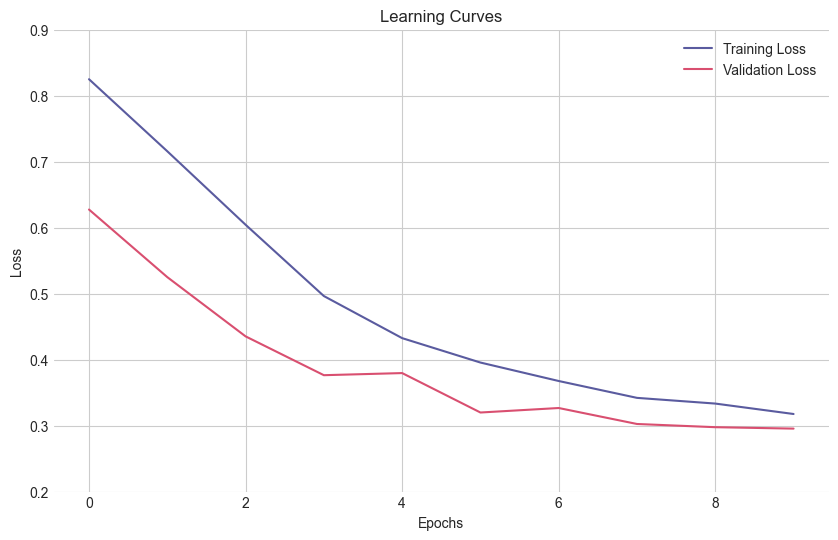

In [18]:
# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.2, 0.9)
plt.title('Learning Curves')
plt.show()

The DL model is performing well on its own, with a validation accuracy of 87.48% and good results in the learning curves. We can now move on to using features from the DL model to improve the performance of a classical ML model using feature extraction.

In [19]:
# View all layers of the LSTM model
model.layers

[<InputLayer name=input_layer, built=True>,
 <Embedding name=embedding, built=True>,
 <Bidirectional name=bidirectional, built=True>,
 <Attention name=attention, built=True>,
 <Dropout name=dropout, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <LSTM name=lstm_1, built=True>,
 <Dropout name=dropout_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout_2, built=True>,
 <BatchNormalization name=batch_normalization_2, built=True>,
 <Dense name=dense_1, built=True>]

We extract features and create a new model using only the layers up to the LSTM. This is done to use the high-level features, which capture the deeper patterns and semantics of the text.

In [20]:
# Extract features from the LSTM model
lstm_model = Model(input, lstm)
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 270)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 270, 128)  │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 270, 64)   │     41,216 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 270, 64)   │          1 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 270, 64)   │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 270, 64)   │        256 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 693,889 (2.65 MB)

 Trainable params: 693,761 (2.65 MB)

 Non-trainable params: 128 (512.00 B)

We generate predictions for both the training and testing data, which are the activations or outputs from the LSTM layer.

In [21]:
X_train_lstm = lstm_model.predict(X_train, verbose=0)
X_test_lstm = lstm_model.predict(X_test, verbose=0)

print("Shape of extracted features (train):", X_train_lstm.shape)
print("Shape of extracted features (test):", X_test_lstm.shape)

Shape of extracted features (train): (24904, 32)
Shape of extracted features (test): (25000, 32)


Using a loop to run all the main classification algorithms. It evaluates each algorithm and provides performance scores to find out which one performs the best.

In [22]:
from sklearn.preprocessing import StandardScaler
from alive_progress import alive_it

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Scale data before using in models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lstm)
X_test_scaled = scaler.transform(X_test_lstm)

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': HistGradientBoostingClassifier(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(verbose=0)
}

# Define evaluation metrics
metrics = {
    'Accuracy': accuracy_score,
    'Precision (Class 0)': lambda y_true, y_pred: precision_score(y_true, y_pred, pos_label=0),
    'Precision (Class 1)': lambda y_true, y_pred: precision_score(y_true, y_pred, pos_label=1),
    'Recall (Class 0)': lambda y_true, y_pred: recall_score(y_true, y_pred, pos_label=0),
    'Recall (Class 1)': lambda y_true, y_pred: recall_score(y_true, y_pred, pos_label=1),
    'F1-score (Class 0)': lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label=0),
    'F1-score (Class 1)': lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label=1),
    'ROC AUC': roc_auc_score
}

# Initialize results dictionary
results = {metric: {name: None for name in classifiers} for metric in metrics}

# Evaluate classifiers and store results for each metric
for name, classifier in alive_it(classifiers.items(), force_tty=True, stats="eta: {eta}"):
    classifier.fit(X_train_scaled, y_train)
    y_pred = classifier.predict(X_test_scaled)
    for metric_name, metric_func in metrics.items():
        results[metric_name][name] = metric_func(y_test, y_pred)

# Sort and filter DataFrame for readability
metrics_df = pd.DataFrame(results)
metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
metrics_df['Accuracy'] = (metrics_df['Accuracy'] * 100).round(2).astype(str) + '%'
metrics_df.index.name = 'Algorithm'
metrics_df

|████████████████████████████████████████| 9/9 [100%] in 53.2s (0.14/s)         


,Accuracy,Precision (Class 0),Precision (Class 1),Recall (Class 0),Recall (Class 1),F1-score (Class 0),F1-score (Class 1),ROC AUC
Algorithm,,,,,,,,
SVM,87.44%,0.870909,0.878039,0.87920,0.86968,0.875035,0.873839,0.87444
Logistic Regression,87.44%,0.871960,0.876872,0.87768,0.87112,0.874811,0.873987,0.87440
Random Forest,87.36%,0.869218,0.878005,0.87944,0.86768,0.874299,0.872812,0.87356
Naive Bayes,87.34%,0.877416,0.869469,0.86808,0.87872,0.872723,0.874070,0.87340
Gradient Boosting,87.29%,0.869159,0.876677,0.87792,0.86784,0.873517,0.872236,0.87288
LightGBM,87.22%,0.868175,0.876395,0.87776,0.86672,0.872941,0.871531,0.87224
XGBoost,86.84%,0.865255,0.871681,0.87280,0.86408,0.869011,0.867864,0.86844
K-Nearest Neighbors,86.51%,0.860278,0.870094,0.87184,0.85840,0.866020,0.864207,0.86512
Decision Tree,83.3%,0.829821,0.836323,0.83792,0.82816,0.833851,0.832221,0.83304


Based on all the metrics, SVM is the best option, so we will proceed with it.

In [23]:
# Fit model with the chosen algorithm
svm = SVC()
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88     12500
           1       0.88      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



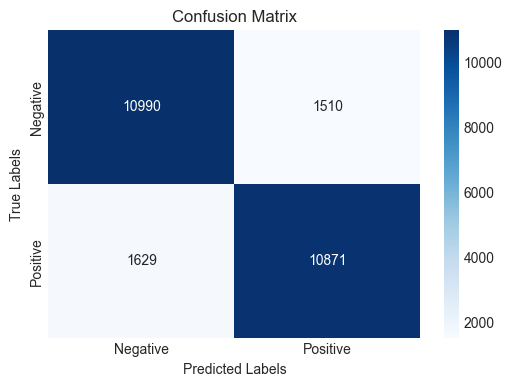

In [24]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ["Negative", "Positive"]

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The classification report and confusion matrix show strong results for the final model. Even though there's no improvement in accuracy compared to the DL model, the primary objective of this experiment is to demonstrate how feature extraction can be used in a hybrid approach to enhance model efficiency.

The dataset used in this notebook is quite outdated, as it was last updated 5 years ago. To test the model’s performance, we use reviews from newer movies. We chose random reviews from movies in the highest-grossing movies list as of August 2024 and put them in a .csv file. The links to the reviews are:

* https://www.imdb.com/review/rw4799099/?ref_=tt_urv - Avengers: Endgame (2019) - positive
* https://www.imdb.com/review/rw7654840/?ref_=tt_urv - Spider-Man: No Way Home (2021) - mixed/negative
* https://www.imdb.com/review/rw9005397/?ref_=tt_urv - Avatar: The Way of Water (2022) - negative

In [25]:
# Load the new reviews file
df_reviews = pd.read_csv("new_reviews.csv", encoding='utf-8')

In [26]:
df_reviews.head()

,movie,review
0,Avengers: Endgame (2019),I feel like I'm wasting my time writing down m...
1,Spider-Man: No Way Home (2021),So for me to really love a movie i have to lov...
2,Avatar: The Way of Water (2022),I struggled to get through this film. It was j...


In [27]:
# Extract reviews from the DataFrame
new_reviews = df_reviews['review'].tolist()

Use the Tokenizer that was trained on the training data. Make sure not to train the Tokenizer again; just convert the text to sequences.

In [28]:
# Calculate average review length
average_length = df_reviews['review'].apply(lambda x: len(x.split())).mean()

print(f"The average length of the new reviews is: {average_length:.0f} words")

The average length of the new reviews is: 239 words


In [29]:
# Convert new reviews to sequences
new_sequences = tokenizer.texts_to_sequences(new_reviews)

# Pad sequences
new_sequences = pad_sequences(new_sequences, maxlen=250, padding='post')

We make predictions and display the results to evaluate the model's performance on real-world data.

In [30]:
# Extract features for new reviews
new_features = lstm_model.predict(new_sequences, verbose=0)

# Predict sentiments
sentiment_predictions = svm.predict(new_features)

In [31]:
# Create a DataFrame with reviews and predictions
results_df = pd.DataFrame({
    'review': new_reviews,
    'predicted sentiment': ['positive' if pred == 1 else 'negative' for pred in sentiment_predictions]
})

results_df

,review,predicted sentiment
0,I feel like I'm wasting my time writing down m...,positive
1,So for me to really love a movie i have to lov...,negative
2,I struggled to get through this film. It was j...,negative
